# Bayes by Backprop

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

tfk = tf.keras
tfkl = tfk.layers 
tfd = tfp.distributions
tfpl = tfp.layers

print("Tensorflow Version: %s" % tf.__version__)
print("Tensorflow Probability Version: %s" % tfp.__version__)

if tf.test.gpu_device_name() != '/device:GPU:0':
    print('GPU device not found. Using CPU')
else:
    print('Found GPU: {}'.format(tf.test.gpu_device_name()))

Tensorflow Version: 2.0.0-beta1
Tensorflow Probability Version: 0.8.0-dev20190619
Found GPU: /device:GPU:0


In [3]:
# load commons and models module
import os
import sys
import importlib

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import commons as cm
import models 
importlib.reload(cm)
importlib.reload(models)

Tensorflow Version: 2.0.0-beta1
Tensorflow Probability Version: 0.8.0-dev20190619
Found GPU: /device:GPU:0


<module 'models' from 'D:\\Tom\\Documents\\gitworkspace\\master\\ml-probability\\tfp_word_embeddings\\models.py'>

# Configuration, Parameters and Setup

In [3]:
# Only needs to be run once per enviroment. Downloads requiered wordnet package for nltk 
cm.one_time_setup()

# Also make sure to have access to the pretrained GloVe embedding model.
# We use glove.6B.zip from https://nlp.stanford.edu/projects/glove/

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Tom\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
# Directory containing the GloVe files.
glove_dir = "D:/google drive/haw/master/mastertheisis/hauptprojekt/glove"

# Directory containing the trained model
models_dir = "D:/google drive/haw/master/mastertheisis/hauptprojekt/training/models"

# Directory containing the training history
history_dir = "D:/google drive/haw/master/mastertheisis/hauptprojekt/training/history"

# Embedding dimension (all models are pretrained for dimension 50)
embedding_dim = 50

# Fraction of the training dataset to be used. 
dataset_sizes=[1.0, 0.8, 0.6, 0.4, 0.2, 0.1, 0.01]
dataset_size = dataset_sizes[0]

# batch size for training
batch_size = 128

# training epochs 
epochs = 50

# hidden layers where each element denotes the number of neurons
neurons_hidden_layers = [64, 64, 32]

# variational layer implementation 
variational_layer = [
    tfpl.DenseFlipout,
    tfpl.DenseReparameterization
][0]

In [7]:
setup = cm.setup(glove_dir=glove_dir,
                 embedding_dim=embedding_dim,
                 dataset_size=dataset_size)
(x_train, x_train_padded, y_train) = setup["train"]
(x_test, x_test_padded, y_test) = setup["test"]
word_index = setup["word_index"]

# number of data points
N = x_train.shape[0]

Found 400000 word vectors.
17361/88587 unknown words


# Model

In [8]:
bayes_by_backprop_model = models.BayesByBackpropModel(model_setup=setup,
                                                      models_dir=models_dir,
                                                      history_dir=history_dir,
                                                      variational_layer=variational_layer,
                                                      neurons_hidden_layers=neurons_hidden_layers)

In [9]:
bayes_by_backprop_model.keras_summary()

Model: "bayes_by_backprop_DenseFlipout_23750_64_64_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2800, 50)          4429400   
_________________________________________________________________
dense_flipout (DenseFlipout) (None, 2800, 64)          6464      
_________________________________________________________________
dense_flipout_1 (DenseFlipou (None, 2800, 64)          8256      
_________________________________________________________________
dense_flipout_2 (DenseFlipou (None, 2800, 32)          4128      
_________________________________________________________________
flatten (Flatten)            (None, 89600)             0         
_________________________________________________________________
dense_flipout_3 (DenseFlipou (None, 1)                 179201    
Total params: 4,627,449
Trainable params: 198,049
Non-trainable params: 4,429,400
_____

In [11]:
bayes_by_backprop_model.fit(epochs=epochs, batch_size=batch_size)

using saved model
Loaded history successfully. Last epoch: 50
Train on 23750 samples, validate on 1250 samples


# History

In [15]:
(history_df, last_epoch) = bayes_by_backprop_model.load_history()

Loaded history successfully. Last epoch: 50


# Tests

In [12]:
model = bayes_by_backprop_model.load_model()
loss, accuracy, *other = model.evaluate(x_test_padded, y_test)
print("Test loss: %.2f\nTest accuracy: %.2f%%" % (loss, accuracy * 100))

using saved model
25000/25000 [==============================] - 33s 1ms/sample - loss: 0.9690 - acc: 0.8353 - true_negatives: 10463.0000 - false_negatives: 2081.0000 - true_positives: 10419.0000 - false_positives: 2037.0000 - precision: 0.8365 - recall: 0.8335 - kl: 0.2090
Test loss: 0.97
Test accuracy: 83.53%


using saved model


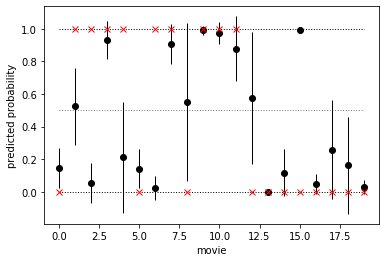

In [13]:
model = bayes_by_backprop_model.load_model()
n = 20
samples = 75

y_pred = [model.predict(x_test_padded[:n]) for i in range(samples)]
y_pred = np.array(y_pred)

means = [np.mean(y_pred[:, i]) for i in range(n)]
stddevs = [np.std(y_pred[:, i]) for i in range(n)]
cm.plot_confidence(means, stddevs, y_test[:n])

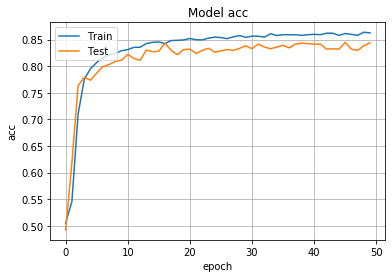

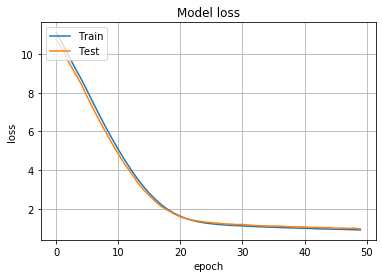

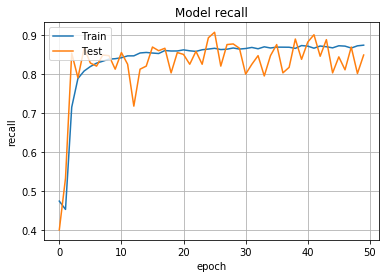

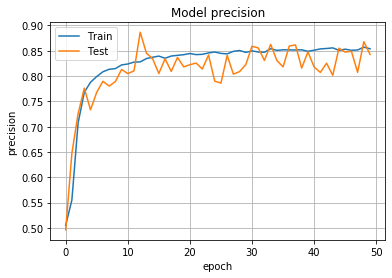

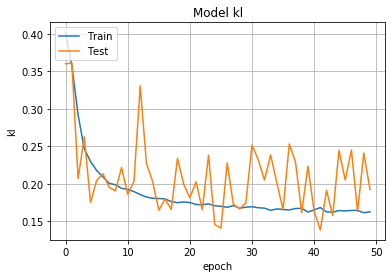

In [16]:
for metric in ["acc", "loss", "recall", "precision", "kl"] :
    cm.plot_metric(metric, history_df)
    plt.show()